In [64]:
import juliet
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import lightkurve as lk
import transitleastsquares as tls
import sys
from scipy.stats import median_absolute_deviation

In [43]:
def weighted_avg_and_std(values, weights):
    """ Return the weighted average and standard deviation. values, weights -- Numpy ndarrays with the same shape."""
    average = np.average(values, weights=weights) #weights = 1./err_bar^2. Where err_bar=std & err_bar^2 = variance
    variance = np.average((values-average)**2, weights=weights) # Fast and numerically precise
    return average, np.sqrt(variance)

def BinDat(time, LC, LC_err, Bin=100):
    """Method to bin the data, using the weighted mean of a given databin size 'Bin.' The error is estimated using the
    technique discussed here https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-numpy"""
    Remainder = len(LC)%Bin
    LenSplit = int(np.trunc(len(LC)/Bin))
    if Remainder > 0: #To collect remainders for the last bin
        Main, mainErr, mainT= LC[:len(LC)-Remainder], LC_err[:len(LC_err)-Remainder], time[:len(time)-Remainder]
        Remain, RemainErr, remainT= LC[len(LC)-Remainder:], LC_err[len(LC_err)-Remainder:], time[len(time)-Remainder:]
        size = LenSplit+1
    else:
        Main, mainErr, mainT = LC, LC_err, time
        size = LenSplit
    BinLC, BinLCerr, BinT = np.zeros(size), np.zeros(size), np.zeros(size)
    Splits, splitErr, splitT = np.split(Main, LenSplit), np.split(mainErr, LenSplit), np.split(mainT, LenSplit)
    if Remainder: 
        Splits.append(Remain), splitErr.append(RemainErr), splitT.append(remainT)
    for S in range(len(Splits)):
        Avg, Err = weighted_avg_and_std(Splits[S], 1/(splitErr[S]**2)) #weight = 1/variance = 1/sig^2 = 1/err_bar^2
        BinLC[S], BinLCerr[S], BinT[S] = Avg, Err, np.mean(splitT[S])
    return BinLC, BinLCerr, BinT

def PlotBestFit(Data, best_P, Amp, BinSize=100, convert2ppm=True):
    #Data = [time, flux, flux_error]
    LC = lk.LightCurve(Data[0],Data[1],Data[2])
    LC_fold = LC.fold(best_P)
    if BinSize == None:
        binned_lc, binned_lc_err, binned_lc_time = LC_fold.flux, LC_fold.flux_err, LC_fold.time
        BinSize, Binned = len(binned_lc), False
    else:
        Binned = True
        binned_lc, binned_lc_err, binned_lc_time = BinDat(LC_fold.time, LC_fold.flux, LC_fold.flux_err, Bin=BinSize)
    
    if convert2ppm:
        flux, bin_flux = (LC_fold.flux-1)*1e6, (binned_lc-1)*1e6
        flux_err, bin_flux_err = LC_fold.flux_err*1e6, binned_lc_err*1e6
        Amp = Amp*1e6
        shift = 0
    else:
        flux, bin_flux, flux_err, bin_flux_err = LC_fold.flux, binned_lc, LC_fold.flux_err, binned_lc_err
        shift= 1# amplitude quoted is relative to mean, so if not converted to ppm have to shift the sine curve fit up to mean=1
    phase = np.linspace(-0.5, 0.5, BinSize)
    phased_times = phase*best_P
    y1 = Amp*np.sin(1/(np.pi)*phased_times)+shift #not sure if this is supposed to be sine or cosine, or if the .5 is supposed to be there> Do want one full oscillation in time span of -.5 to .5
    y3 = Amp*np.cos(1/(np.pi)*phased_times)+shift 
    plt.errorbar(binned_lc_time, bin_flux, bin_flux_err, ls='', marker='o', mfc='white', ms=4, mew=1, zorder=10, label = 'Amp = '+str(Amp))    
    if Binned: #want to zoom in on the binned data, so getting bounds of the binned data
        MaxRng = np.max(bin_flux+bin_flux_err)
        MinRng = np.min(bin_flux-bin_flux_err)
        plt.plot(LC_fold.time, flux, 'k.', ms=2, alpha=0.2, rasterized=True) #also plot the unbinned data
        plt.ylim(MinRng, MaxRng)
    plt.plot(phase, y1, 'r--', linewidth = 7, zorder=10)
    plt.plot(phase, y3, 'y--', linewidth = 7, zorder=10)
    plt.xlabel('Phase')
    plt.ylabel('Normalized Flux (ppm)')
    return None

# WASP-6

In [84]:
#To load the previously reduced data
Path = 'TESS/Juliet/WASP6/AITnASASSNncombinedTESSpass1'
dataset = juliet.load(input_folder=Path, out_folder=Path)
results = dataset.fit()

Detected multinest sampler output files --- extracting from TESS/Juliet/WASP6/AITnASASSNncombinedTESSpass1/posteriors.pkl


### TESS data

In [59]:
def get_tess_lc(target, PLOT =True, obs=0):
    #obs==if target has been obseerved more than once, specify which observation you want to analize
    sr = lk.search_lightcurvefile(target, mission='TESS')[obs]
    lcfs = sr.download_all()
    lc0 = lcfs.PDCSAP_FLUX.stitch().remove_nans()
    if PLOT:
        lc0.errorbar(marker='.', alpha=0.5)
        plt.savefig(f'{target}_tess_lc.pdf', bbox_inches='tight')
        plt.show()
        plt.close()
    return lc0

In [60]:
def mask_transits(lc0, t0, p, d, PLOT = True):
    intransit = tls.transit_mask(lc0.time, p, d, t0)
    lc = lc0[~intransit]
    if PLOT:
        lc.errorbar(marker='.', alpha=0.5)
        plt.savefig(f'{target}_tess_lc_transits_masked.pdf', bbox_inches='tight')
        plt.show()
        plt.close()
    return lc

SearchResult containing 3 data products.

 #   observation   target_name                       productFilename                        distance
--- -------------- ----------- ------------------------------------------------------------ --------
  0  TESS Sector 2   204376737      tess2018234235059-s0002-0000000204376737-0121-s_lc.fits      0.0
  1 TESS Sector 29   204376737 tess2020238165205-s0029-0000000204376737-0193-a_fast-lc.fits      0.0
  2 TESS Sector 29   204376737      tess2020238165205-s0029-0000000204376737-0193-s_lc.fits      0.0 

 WASP6 


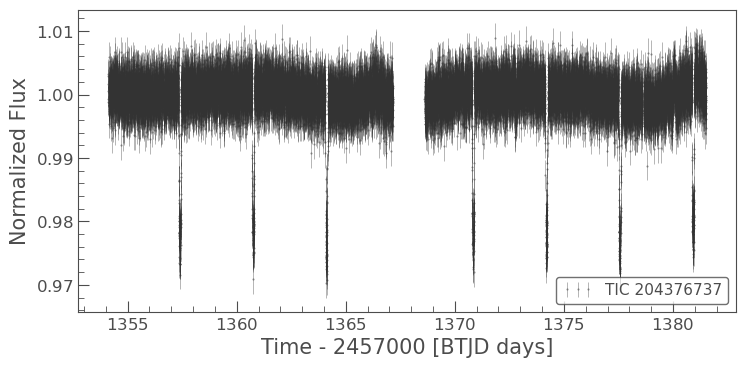

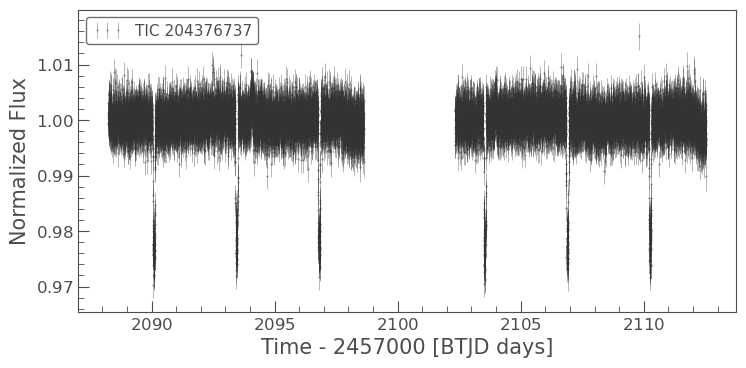

 WASP6 


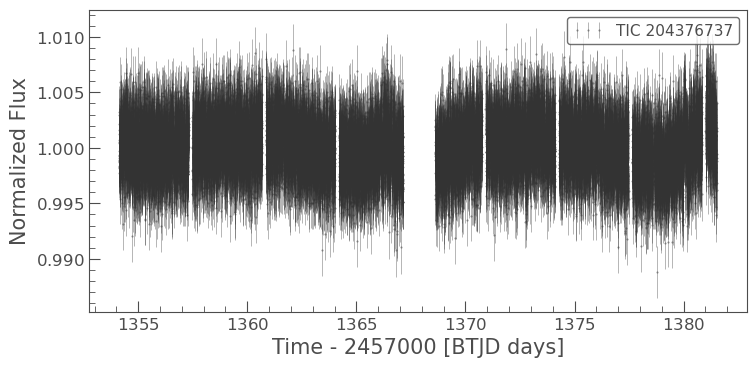

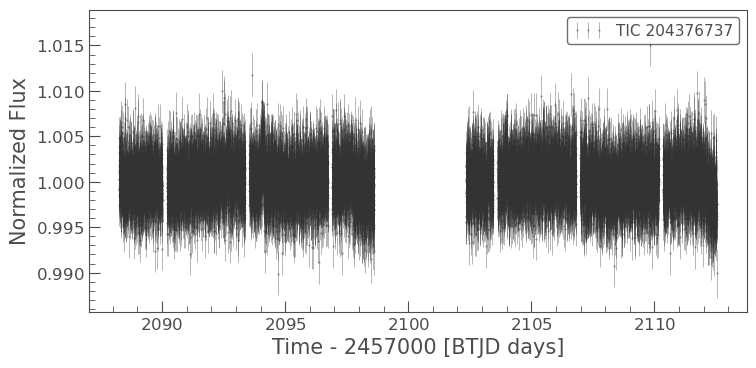

In [63]:
target = 'WASP-6'
print (lk.search_lightcurvefile(target, mission='TESS'),"\n")
print ('\033[1m WASP6 \033[0m')
lc_epc1 = get_tess_lc(target, PLOT=True, obs=0)
lc_epc2 = get_tess_lc(target, PLOT=True, obs=2)
#W6
t0 = 1357.394531 #2090.097109 for 2nd TESS observation
p = 3.361021
d = 1.5*2.579176/24. #transit duration
print ('\033[1m WASP6 \033[0m')
lc_OOT1 = mask_transits(lc_epc1, t0, p, d, PLOT = True)
lc_OOT2 = mask_transits(lc_epc2, 2090.097109, p, d, PLOT = True)

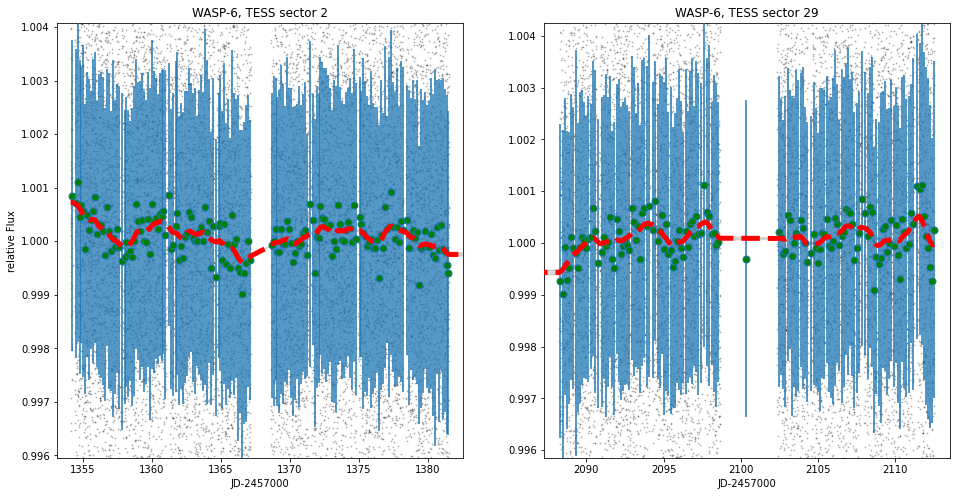

Standard deviation: 0.0028228431
median absolute deviation: 0.0027944312810897825


In [115]:
BinSize = 100
modelTimeTESS = dataset.times_lc['TESS']
modelTESS, error68_upTESS, error68_downTESS = results.lc.evaluate('TESS', return_err=True)
                                                         
plt.figure(1, figsize=(16,8))
plt.subplot(121)
plt.title("WASP-6, TESS sector 2")
MinT1, MaxT1 = np.min(lc_OOT1.time), np.max(lc_OOT1.time)
binned_lc1, binned_lc_err1, binned_lc_time1 = BinDat(lc_OOT1.time, lc_OOT1.flux, lc_OOT1.flux_err, Bin=BinSize)
plt.plot(lc_OOT1.time, lc_OOT1.flux, 'k.', ms=2, alpha=0.2, rasterized=True)
plt.plot(modelTimeTESS, results.lc.evaluate('TESS'), 'r--', linewidth = 5, zorder=10)
plt.errorbar(binned_lc_time1, binned_lc1, binned_lc_err1, ls='', marker='o', mfc='green', ms=7, mew=1, zorder=8) 
plt.fill_between(modelTimeTESS, error68_downTESS, error68_upTESS, color='grey',alpha = 0.3)
MinF1, MaxF1 = np.max(binned_lc1+binned_lc_err1), np.min(binned_lc1-binned_lc_err1)
plt.xlim((MinT1-1, MaxT1+1))
plt.ylim((MaxF1, MinF1))
plt.ylabel('relative Flux')
plt.xlabel('JD-2457000')

plt.subplot(122)
plt.title("WASP-6, TESS sector 29")
MinT2, MaxT2 = np.min(lc_OOT2.time), np.max(lc_OOT2.time)
binned_lc2, binned_lc_err2, binned_lc_time2 = BinDat(lc_OOT2.time, lc_OOT2.flux, lc_OOT2.flux_err, Bin=BinSize)
plt.plot(lc_OOT2.time, lc_OOT2.flux, 'k.', ms=2, alpha=0.2, rasterized=True)
plt.plot(dataset.times_lc['TESS'], results.lc.evaluate('TESS'),'r--', linewidth = 5, zorder=10)
plt.errorbar(binned_lc_time2, binned_lc2, binned_lc_err2, ls='', marker='o', mfc='green', ms=7, mew=1, zorder=8) 
plt.fill_between(modelTimeTESS, error68_downTESS, error68_upTESS, color='grey',alpha = 0.3)
MinF2, MaxF2 = np.max(binned_lc2+binned_lc_err2), np.min(binned_lc2-binned_lc_err2)
plt.xlim((MinT2-1, MaxT2+1))
plt.ylim((MaxF2, MinF2))
plt.xlabel('JD-2457000')

plt.show()
plt.close()

allTess_Flux  = np.concatenate((lc_OOT1.flux, lc_OOT1.flux))
print("Standard deviation:", np.std(allTess_Flux))
print("median absolute deviation:", median_absolute_deviation(allTess_Flux))

### ASAS-SN data

In [28]:
def Readcsvdat(file, deliminator = ',', rm_bad_frames=True): #to read csv data. particularly advantageous when data is list of string and float elements
    #rm_bad_frames=to remove bad frame, which are frames with the mag, mag_err, flux, and flux_err being 99.9
    txt = open(file, 'r')
    Titles = txt.readline() #to read first line of file, which contains the string titles of data
    titles = Titles.split(deliminator)
    Data = {}
    Len, Cnt = len(titles)-1, 0
    for tit in titles:
        if Cnt == Len: #to get rid of the '\n' at the end of the last element
            Data[tit[:-1]] = []
        else:
            Data[tit] = []
        Cnt +=1
    Keys = (list(Data)) #cause py3 is stupid can't do Data.keys() to get a list anymore
    cnt = 0
    Arrys = [True]*len(Keys) #initially assuming all data can be converted to arry 
    for line in txt: 
        if cnt == 0: #first line is just names of files
            pass
        else:
            numb = line.split(deliminator)
            if rm_bad_frames:
                if numb[-2] == numb[-3] == numb[-4] == numb[-5] == '99.990':
                    continue
            for i in range(len(Keys)):
                if '\n' in numb[i]: #at the last element of line, which has a new line break
                    numb[i] = numb[i][:-1] #Want to exclude those txts
                try: # if can be converted to a float do it
                    val = float(numb[i])
                except: #else, let it be a striing
                    val = numb[i]
                    Arrys[i] = False
                Data[Keys[i]].append(val)
        cnt +=1
    for a in range(len(Arrys)): # to convert the list of floats to an np.arry
        if Arrys[a]:
            Data[Keys[a]] = np.array(Data[Keys[a]])
    return Data

def unique(list1): # function to get unique values from list  
    # intilize a null list 
    unique_list = [] 
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    return unique_list

def PullAppropDat(Data, Key='mag', TypeKey = None, Type = None, JDreduce = 2450000): #To pull the data need. In the appropriate from i.e. ignore bad observations and data using a specific filter
    #to get only data of specific type. i.e. only V band observations
    if TypeKey != None and Type != None:
        Range = MatchDatType(Data, TypeKey, Type) 
        data = Data[Key][Range]
    else:
        data = Data[Key]
    
    #To include errors
    if Key == 'flux(mJy)':
        ErrKey = 'flux_err'
    else:
        ErrKey = 'mag_err'
        
    #The bad observations are given values of 99.99 for some reason. To get rid of those    
    Del = np.where(data == 99.99) 
    data = np.delete(data, Del)
    time_clean = np.delete(Data['HJD'][Range], Del)
    time = time_clean-JDreduce
    err = np.delete(Data[ErrKey][Range], Del)
    return data, time, err

def MatchDatType(Data, Key, Type): #To get the data that fits a specified type given
    indices = [i for i, x in enumerate(Data[Key]) if x == Type]
    return indices

def SigClip(Data, Key='mag', TypeKey = None, Type = None, thresh = 3, binSize = None, ReturnMod = False, JDreduce=2450000, PLOT =False): 
    """To sig clip data from fitted GP model. thresh = number of std that will be removed"""
    #to get only data of specific type. i.e. only V band observations. remove bad files. and subtract 2.45e6 from JD
    #Key = 'mag' or 'flux(mJy)'
    if type(Data) == str: #then data was given as file name that must be read in
        Data = Readcsvdat(Data)
        data, time, err = PullAppropDat(Data, Key=Key, TypeKey=TypeKey, Type=Type, JDreduce=JDreduce)
    else: #otherwise expecting an array of arrays where the 1st, 2nd, and 3rd elements are the flux/mag, time, and error respectively
        data, time, err = Data[0], Data[1], Data[2]
    #To use the binned values to find the 'model.' For ASAS-SN data likely won't need to do this
    if binSize:
        Err = np.ones(len(data)) #errors don't matter here
        Model, Unimportant, Time  = BinDat(time, data, Err, Bin=binSize)
        FullMod = np.interp(time, Time, Model)
    else: #if there is no obvious features in photometry, just use a flat line of mean as model. This is what we expect for an inactive star
        FullMod = np.ones(len(time))*np.mean(data)
    
    #Mark values that higher than the mean by the given threshold
    std = np.std(data)
    resid = np.abs(data-FullMod)
    Outliers = np.where(resid > std*thresh)[0]
    if PLOT:
        plt.figure(figsize = (18,7))
        if Type:
            TiTlE = 'Sigma Clipped photomitric light curve of '+Type+'_'+Key
        else:
            TiTlE = 'Sigma Clipped photomitric light curve of '+Key
        plt.title(TiTlE)
        plt.plot(time, data, 'b.', label = 'Data')
        plt.plot(time[Outliers], data[Outliers], 'r.', label = 'outliers')
        plt.plot(time, FullMod, 'k--', label = 'Model/mean')
        plt.ylabel('Normalized '+Key)
        plt.xlabel('JD-2450000')
        # plt.legend()
        # plt.show()
        # plt.close()        
    if ReturnMod:
        return Outliers, time, data, err, FullMod
    else:
        return Outliers, time, data, err
    
triangular_number = lambda n: int(n)*(int(n)+1)//2 #this is addition factorial. i.e X+(X-1)+(X-2)+(X-3)...

# to make a code that averages the datapoints that are close in time
def BinnedLC(time, flux, flx_err, diff_lim=.1): # diff_lim = max difference in time [days]. 0.1 = 2.4hrs
    
    #To block togther all datapoints that have similar times stamps
    DiffGroupTotal = [] #This will be a list of list, where each list holds the indeces that should be combined 
    DiffGroup_i = [] #To keep track of elements that should be combined
    Start_i, end_i = 0, 1 #The 1st index of DiffGroup_i. end_i is initalized to Start_i+1
    for d in range(0,len(time)-1):
        if time[d+1]-time[Start_i]<diff_lim: #If the 1st element (Start_i) and the last element searched (end_i) have a time difference less than 'diff_lim,' add those indeces
            if len(DiffGroup_i) == 0: #Starting new group cointaining small time differences amongst them
                DiffGroup_i.append(Start_i) #add start to the list of close times
                DiffGroup_i.append(d+1)
                Start_i = d #To keep track of where DiffGroup_i started
            else: #if DiffGroup_i already initialized, add next element to our list
                DiffGroup_i.append(d+1)
        else:
            if len(DiffGroup_i) > 1: # if the previous step was the last step in the grouped times, append the DiffGroup_i to DiffGroupTotal
                DiffGroupTotal.append(DiffGroup_i)
            if time[d+1]-time[d]> diff_lim and d not in DiffGroup_i: #only add individual element if not going to go
                DiffGroupTotal.append([d]) #in the next list
            Start_i= d+1 #reset Start_i
            DiffGroup_i = [] #rest the group list
    if len(DiffGroup_i) > 1: # For the last element
        DiffGroupTotal.append(DiffGroup_i)
    else:
        DiffGroupTotal.append([d+1])
     
    #Extra checks to make sure all the indecies are accounted for in the right sub-lists:
    TotalSum = 0 #to check if adds
    for i in range(len(DiffGroupTotal)): #To scan each sublist
        sublist = DiffGroupTotal[i]
        FirstTime, LastTime = time[sublist[0]], time[sublist[-1]]
        if LastTime-FirstTime > diff_lim: #To make sure the differences of the indeces I marked in each subdirectory are indeed within the approporate limit
            sys.exit("In sublist "+str(i)+", the 1st and last times are "+str(FirstTime)+","+str(LastTime)+". Their difference is greater than diff_lim!!!!")
        TotalSum += np.sum(sublist)
    Traiangle = triangular_number(len(time)-1) #triangle number of len(time)-1, to makes sure every index is accounted for
    if TotalSum != Traiangle:
        print ("Sum of all indeces is "+str(TotalSum)+". However, the triangle number of the inputed time array length is "+str(Traiangle)+".") 
        print ("DiffGroupTotal", DiffGroupTotal)
        sys.exit()
        
    #To weight average all blocked data
    new_time, new_flux, new_FlxErr = [], [], []
    for g in DiffGroupTotal:
        if len(g) == 1:
            new_time.append(time[g][0]),  new_flux.append(flux[g][0]), new_FlxErr.append(flx_err[g][0])
        else:
            Flux, STD = weighted_avg_and_std(flux[g], 1./(flx_err[g]**2))
            new_time.append(np.mean(time[g])),  new_flux.append(Flux), new_FlxErr.append(STD)
    
    return np.array(new_time, dtype="object"), np.array(new_flux, dtype="object"), np.array(new_FlxErr, dtype="object") #need the "object" because each array is of different size

def NormFlux(flux, time, err, method='Huitson'): 
    #to compute normalized flux. Could do either the "Huitson" method, which calculates the 'non-spotted flux'
    #or the "simple" method, which is just dividing the data by the mean
    if method.lower() == 'huitson':
        k = 1.
        sigma = np.std(flux)
        mean_flux = np.max(flux) + k*sigma
        y = flux/mean_flux #normalize flux
        yerr = err/mean_flux
    elif method.lower() == 'simple':
        mean_flux = np.mean(flux)
        y = flux/mean_flux #normalize flux
        yerr = err/mean_flux
    else:
        sys.exit("method name of '"+method+"' is not a known normalization method")
    return y, time, yerr, mean_flux #return the mean flux, so can use it for plotting purposes

def UncertaintyClip(data, time, err, threshold=3): # to cut all data with uncertainties higher than 'threshold' times the average. So the really uncertain data doesn't skew the fit
    Mean_err = np.mean(err)
    good_dat = np.where(err<(threshold*Mean_err))
    data_cut, time_cut, err_cut = data[good_dat], time[good_dat], err[good_dat]
    print ("cut error:", len(data)-len(data_cut), "out of datapoints", len(data))
    return data_cut, time_cut, err_cut

In [29]:
filenameMe = 'ASAS-SN/ASASSNPhotMotW6.csv'
Outliers_W6_V, JD_W6_V, Dat_W6_V, Err_W6_V = SigClip(filenameMe,Key='flux(mJy)',TypeKey='Filter',Type='V',PLOT=False) #to identify data that's more than 3 sig from mean
sigClip_timeV, sigClip_fluxV, sigClip_fluxErrV = np.delete(JD_W6_V,Outliers_W6_V), np.delete(Dat_W6_V,Outliers_W6_V), np.delete(Err_W6_V,Outliers_W6_V) #to delete identified data
Binned_timeV, Binned_fluxV, Binned_FlxErrV = BinnedLC(sigClip_timeV, sigClip_fluxV, sigClip_fluxErrV,diff_lim=.1) #to bin data from the same day
uncrtClip_F_V, uncrtClip_T_V, uncrtClip_E_V = UncertaintyClip(Binned_fluxV, Binned_timeV, Binned_FlxErrV)
Final_flxV, Final_tV, Final_ErrV, MeanF_V = NormFlux(uncrtClip_F_V, uncrtClip_T_V, uncrtClip_E_V, method='simple')

Outliers_W6_g, JD_W6_g, Dat_W6_g, Err_W6_g = SigClip(filenameMe,Key='flux(mJy)',TypeKey='Filter',Type='g',PLOT=False)
sigClip_timeg, sigClip_fluxg, sigClip_fluxErrg = np.delete(JD_W6_g,Outliers_W6_g), np.delete(Dat_W6_g,Outliers_W6_g), np.delete(Err_W6_g,Outliers_W6_g)
Binned_timeg, Binned_fluxg, Binned_FlxErrg = BinnedLC(sigClip_timeg, sigClip_fluxg, sigClip_fluxErrg,diff_lim=.1)
uncrtClip_F_g, uncrtClip_T_g, uncrtClip_E_g = UncertaintyClip(Binned_fluxg, Binned_timeg, Binned_FlxErrg)
Final_flxg, Final_tg, Final_Errg, MeanF_g = NormFlux(uncrtClip_F_g, uncrtClip_T_g, uncrtClip_E_g, method='simple')

cut error: 13 out of datapoints 341
cut error: 11 out of datapoints 439


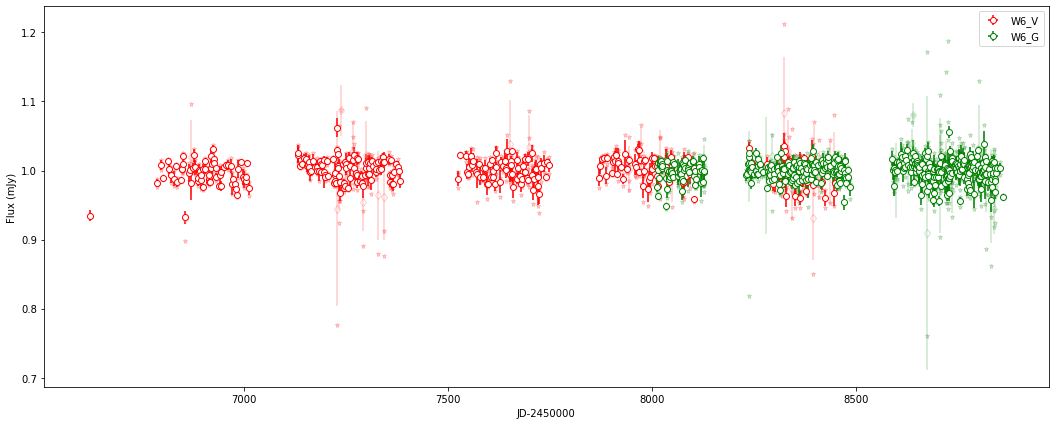

In [30]:
%matplotlib inline
plt.figure(figsize = (18,7))
#
#
#to plot the original data, normalized
RawData = Readcsvdat(filenameMe)
RawDataV, RawTimeV, RawErrV = PullAppropDat(RawData, Key='flux(mJy)',TypeKey='Filter',Type='V')
plt.plot(RawTimeV, RawDataV/MeanF_V , 'r*', alpha =.2)

RawDataG, RawTimeG, RawErrG = PullAppropDat(RawData, Key='flux(mJy)',TypeKey='Filter',Type='g')
plt.plot(RawTimeG, RawDataG/MeanF_g, 'g*', alpha =.2)
#
#
#to plot the normalized binned data, with errorbars 
binRaw_timV, binRaw_fluxV, binRaw_errV = BinnedLC(RawTimeV, RawDataV, RawErrV, diff_lim=.1)
ErrBarsV = [binRaw_errV/MeanF_V, binRaw_errV/MeanF_V]
TimBarsV = [np.zeros(len(binRaw_timV)),np.zeros(len(binRaw_timV))]
plt.errorbar(binRaw_timV, binRaw_fluxV/MeanF_V, ErrBarsV, TimBarsV, 'red', markersize = 6, ls='', marker='d', mfc='white', mew=1, zorder=10, alpha = .2)

binRaw_timG, binRaw_fluxG, binRaw_errG = BinnedLC(RawTimeG, RawDataG, RawErrG,diff_lim=.1)
ErrBarsG = [binRaw_errG/MeanF_g, binRaw_errG/MeanF_g]
TimBarsG = [np.zeros(len(binRaw_timG)),np.zeros(len(binRaw_timG))]
plt.errorbar(binRaw_timG, binRaw_fluxG/MeanF_g, ErrBarsG, TimBarsG, 'green', markersize = 6, ls='', marker='d', mfc='white', mew=1, zorder=10, alpha = .2)
#
#
#to plot the final normalized cut binned data, with errorbars 
NotTimV, NotTimg = np.zeros(len(Final_tV)), np.zeros(len(Final_tg))
plt.errorbar(Final_tV, Final_flxV, [Final_ErrV,Final_ErrV], [NotTimV,NotTimV], 'red', markersize = 6, ls='', marker='o', mfc='white', mew=1, zorder=10, label = 'W6_V')
plt.errorbar(Final_tg, Final_flxg, [Final_Errg,Final_Errg], [NotTimg,NotTimg], 'green', markersize = 6, ls='', marker='o', mfc='white', mew=1, zorder=10, label = 'W6_G')
plt.ylabel('relative Flux (mJy)')
plt.xlabel('JD-2450000')
plt.legend()
plt.show()

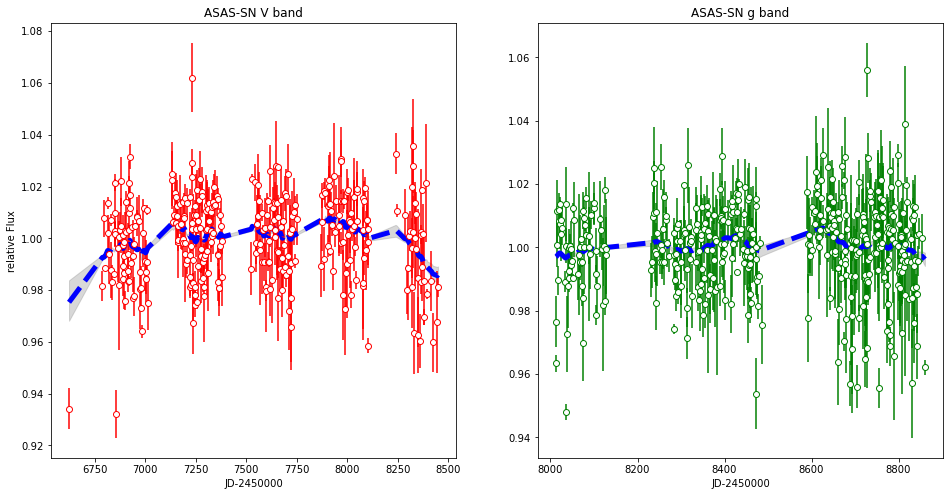

ASAS-SN V band:
Standard deviation: 0.016184785835110415
median absolute deviation: 0.01662404468397932 

ASAS-SN g band:
Standard deviation: 0.013975627288218502
median absolute deviation: 0.01225105076102897 



In [104]:
plt.figure(1, figsize=(16,8))

plt.subplot(121)
plt.title("ASAS-SN V band")
plt.errorbar(Final_tV, Final_flxV, [Final_ErrV,Final_ErrV], [NotTimV,NotTimV], 'red', markersize = 6, ls='', marker='o', mfc='white', mew=1, zorder=10)
modelTimeV = dataset.times_lc['ASASSNv']
modelV, error68_upV, error68_downV = results.lc.evaluate('ASASSNv', return_err=True)
plt.plot(modelTimeV, modelV,'b--', linewidth = 5, zorder=10)
plt.fill_between(modelTimeV, error68_downV, error68_upV, color='grey',alpha = 0.3)
plt.ylabel('relative Flux')
plt.xlabel('JD-2450000')

plt.subplot(122)
plt.title("ASAS-SN g band")
plt.errorbar(Final_tg, Final_flxg, [Final_Errg,Final_Errg], [NotTimg,NotTimg], 'green', markersize = 6, ls='', marker='o', mfc='white', mew=1, zorder=10)
modelTimeG = dataset.times_lc['ASASSNg']
modelG, error68_upG, error68_downG = results.lc.evaluate('ASASSNg', return_err=True)
plt.plot(modelTimeG, modelG,'b--', linewidth = 5, zorder=10)
plt.fill_between(modelTimeG, error68_downG, error68_upG, color='grey',alpha = 0.3)
plt.xlabel('JD-2450000')

plt.show()
plt.close()
allTess_Flux  = np.concatenate((lc_OOT1.flux, lc_OOT1.flux))
print("ASAS-SN V band:")
print("Standard deviation:", np.std(Final_flxV))
print("median absolute deviation:", median_absolute_deviation(Final_flxV),"\n")
print("ASAS-SN g band:")
print("Standard deviation:", np.std(Final_flxg))
print("median absolute deviation:", median_absolute_deviation(Final_flxg),"\n")

### AIT data

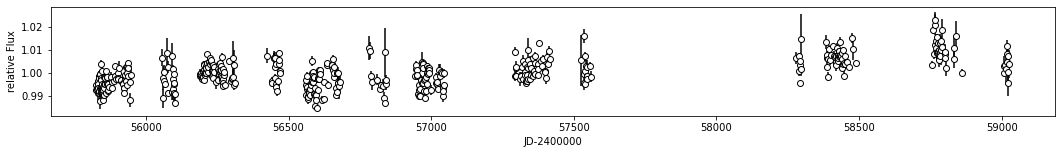

In [122]:
def Mag2Flux(Mag, magErr, refMag, refFlux=1): #convert AIT relative mag to relative flux
    pwr = .4*(refMag-Mag)
    Flux = refFlux*(10**pwr)
    #To estimate error, calculate the flux when upper limit is added to mag and when lower limit is added to mag. Take the difference of the 2
    pwr1, pwr2 = 0.4*(refMag-Mag+magErr), 0.4*(refMag-Mag-magErr)
    Err1, Err2 = abs(Flux-refFlux*(10**pwr1)), abs(Flux-refFlux*(10**pwr2))
    return Flux, np.max(np.array([Err1, Err2]), axis=0)

Time, DeltaR, Err = np.loadtxt('AIT/WASP6/WASP-6.R.all', unpack=True)
Flux, Err = Mag2Flux(DeltaR,Err, -0.195333)

plt.figure(figsize = (18,7))
No = np.zeros(len(Time))
plt.errorbar(Time, Flux, [Err, Err], [No, No], 'k', markersize = 6, ls='', marker='o', mfc='white', mew=1, zorder=10)
plt.ylabel('relative Flux')
plt.xlabel('JD-2400000')
plt.show()
plt.close()

KeyError: 'AIT'

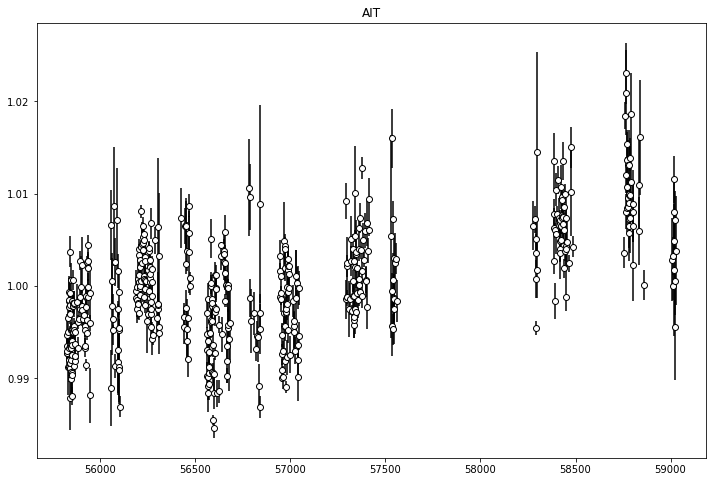

In [121]:
plt.figure(1, figsize=(16,8))

plt.title("AIT")
plt.errorbar(Time, Flux, [Err, Err], [No, No], 'k', markersize = 6, ls='', marker='o', mfc='white', mew=1, zorder=10)
modelTimeAIT = dataset.times_lc['AIT']
modelAIT, error68_upAIT, error68_downAIT = results.lc.evaluate('AIT', return_err=True)
plt.plot(modelTimeAIT, modelAIT,'b--', linewidth = 5, zorder=10)
plt.fill_between(modelTimeAIT, error68_downAIT, error68_upAIT, color='grey',alpha = 0.3)
plt.ylabel('relative Flux')
plt.xlabel('JD-2400000')
plt.show()
plt.close()
print("Standard deviation:", np.std(Flux))
print("median absolute deviation:", median_absolute_deviation(Flux))

# WASP-96

In [109]:
#To load the previously reduced data
Path = 'TESS/Juliet/WASP96/ASASSNnTESSpass2'
dataset = juliet.load(input_folder=Path, out_folder=Path)
results = dataset.fit()

Detected multinest sampler output files --- extracting from TESS/Juliet/WASP96/ASASSNnTESSpass2/posteriors.pkl


### TESS

SearchResult containing 3 data products.

 #   observation   target_name                       productFilename                        distance
--- -------------- ----------- ------------------------------------------------------------ --------
  0  TESS Sector 2   160148385      tess2018234235059-s0002-0000000160148385-0121-s_lc.fits      0.0
  1 TESS Sector 29   160148385 tess2020238165205-s0029-0000000160148385-0193-a_fast-lc.fits      0.0
  2 TESS Sector 29   160148385      tess2020238165205-s0029-0000000160148385-0193-s_lc.fits      0.0 

 WASP96 


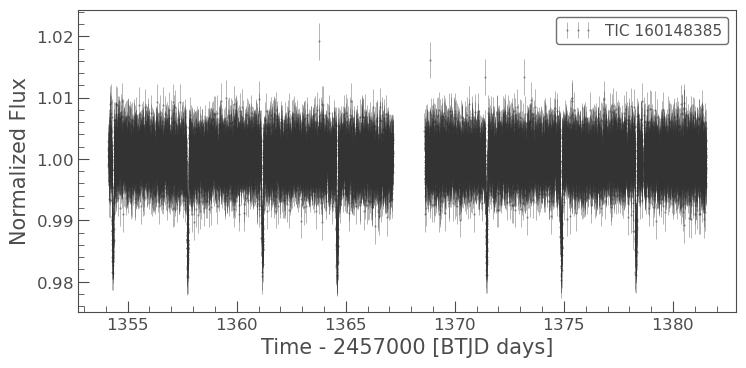

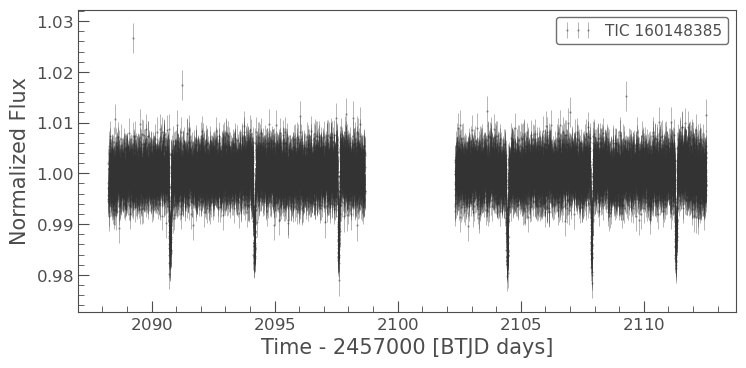

 WASP96 


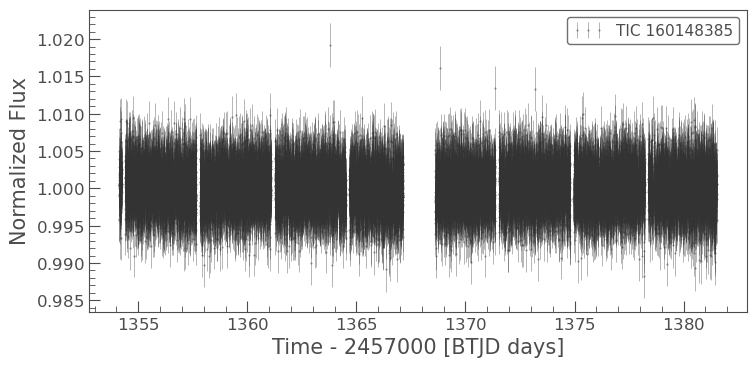

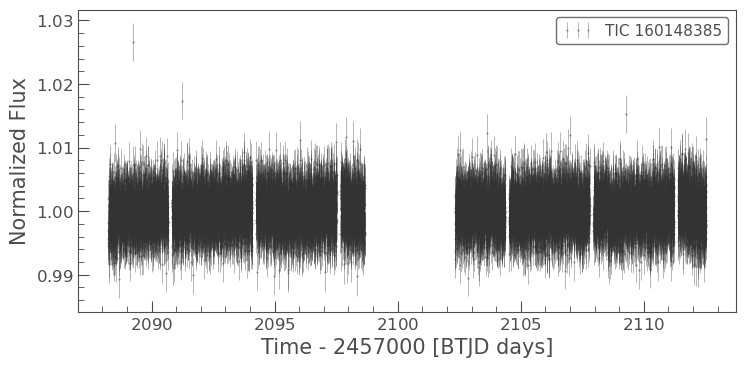

In [108]:
target = 'WASP-96'
print (lk.search_lightcurvefile(target, mission='TESS'),"\n")
print ('\033[1m WASP96 \033[0m')
lc_epc1 = get_tess_lc(target, PLOT=True, obs=0)
lc_epc2 = get_tess_lc(target, PLOT=True, obs=2)
#W96
t0 = 1354.319946
p = 3.425239
d = 1.5*2.44683/24. #transit duration
print ('\033[1m WASP96 \033[0m')
lc_OOT1 = mask_transits(lc_epc1, t0, p, d, PLOT = True)
lc_OOT2 = mask_transits(lc_epc2, t0, p, d, PLOT = True)

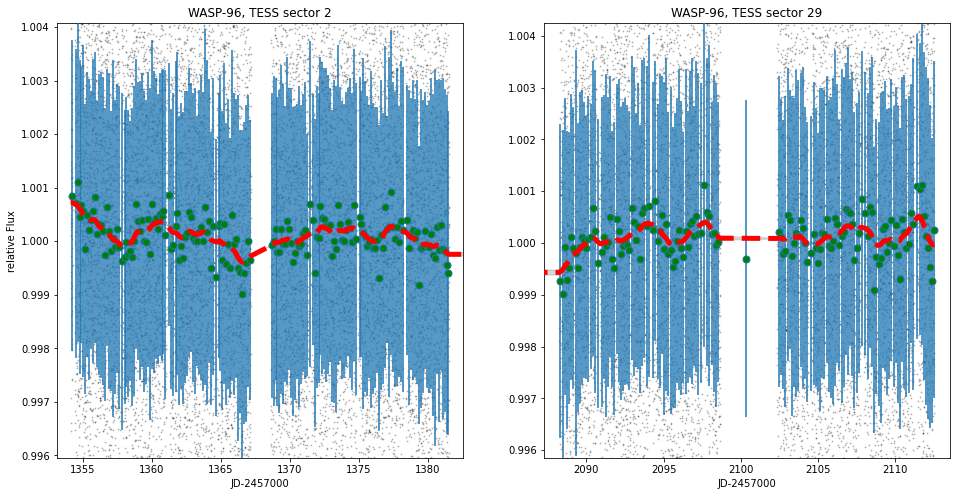

Standard deviation: 0.0028228431
median absolute deviation: 0.0027944312810897825


In [110]:
BinSize = 100
modelTimeTESS = dataset.times_lc['TESS']
modelTESS, error68_upTESS, error68_downTESS = results.lc.evaluate('TESS', return_err=True)
                                                         
plt.figure(1, figsize=(16,8))
plt.subplot(121)
plt.title("WASP-96, TESS sector 2")
MinT1, MaxT1 = np.min(lc_OOT1.time), np.max(lc_OOT1.time)
binned_lc1, binned_lc_err1, binned_lc_time1 = BinDat(lc_OOT1.time, lc_OOT1.flux, lc_OOT1.flux_err, Bin=BinSize)
plt.plot(lc_OOT1.time, lc_OOT1.flux, 'k.', ms=2, alpha=0.2, rasterized=True)
plt.plot(modelTimeTESS, results.lc.evaluate('TESS'), 'r--', linewidth = 5, zorder=10)
plt.errorbar(binned_lc_time1, binned_lc1, binned_lc_err1, ls='', marker='o', mfc='green', ms=7, mew=1, zorder=8) 
plt.fill_between(modelTimeTESS, error68_downTESS, error68_upTESS, color='grey',alpha = 0.3)
MinF1, MaxF1 = np.max(binned_lc1+binned_lc_err1), np.min(binned_lc1-binned_lc_err1)
plt.xlim((MinT1-1, MaxT1+1))
plt.ylim((MaxF1, MinF1))
plt.ylabel('relative Flux')
plt.xlabel('JD-2457000')

plt.subplot(122)
plt.title("WASP-96, TESS sector 29")
MinT2, MaxT2 = np.min(lc_OOT2.time), np.max(lc_OOT2.time)
binned_lc2, binned_lc_err2, binned_lc_time2 = BinDat(lc_OOT2.time, lc_OOT2.flux, lc_OOT2.flux_err, Bin=BinSize)
plt.plot(lc_OOT2.time, lc_OOT2.flux, 'k.', ms=2, alpha=0.2, rasterized=True)
plt.plot(dataset.times_lc['TESS'], results.lc.evaluate('TESS'),'r--', linewidth = 5, zorder=10)
plt.errorbar(binned_lc_time2, binned_lc2, binned_lc_err2, ls='', marker='o', mfc='green', ms=7, mew=1, zorder=8) 
plt.fill_between(modelTimeTESS, error68_downTESS, error68_upTESS, color='grey',alpha = 0.3)
MinF2, MaxF2 = np.max(binned_lc2+binned_lc_err2), np.min(binned_lc2-binned_lc_err2)
plt.xlim((MinT2-1, MaxT2+1))
plt.ylim((MaxF2, MinF2))
plt.xlabel('JD-2457000')

plt.show()
plt.close()

allTess_Flux  = np.concatenate((lc_OOT1.flux, lc_OOT1.flux))
print("Standard deviation:", np.std(allTess_Flux))
print("median absolute deviation:", median_absolute_deviation(allTess_Flux))

### ASAS-SN data

In [111]:
filenameMe = 'ASAS-SN/ASASSNPhotMotW96.csv'
Outliers_W96_V, JD_W96_V, Dat_W96_V, Err_W96_V = SigClip(filenameMe,Key='flux(mJy)',TypeKey='Filter',Type='V',PLOT=False) #to identify data that's more than 3 sig from mean
sigClip_timeV, sigClip_fluxV, sigClip_fluxErrV = np.delete(JD_W96_V,Outliers_W96_V), np.delete(Dat_W96_V,Outliers_W96_V), np.delete(Err_W96_V,Outliers_W96_V) #to delete identified data
Binned_timeV, Binned_fluxV, Binned_FlxErrV = BinnedLC(sigClip_timeV, sigClip_fluxV, sigClip_fluxErrV,diff_lim=.1) #to bin data from the same day
uncrtClip_F_V, uncrtClip_T_V, uncrtClip_E_V = UncertaintyClip(Binned_fluxV, Binned_timeV, Binned_FlxErrV)
Final_flxV, Final_tV, Final_ErrV, MeanF_V = NormFlux(uncrtClip_F_V, uncrtClip_T_V, uncrtClip_E_V, method='simple')

Outliers_W96_g, JD_W96_g, Dat_W96_g, Err_W96_g = SigClip(filenameMe,Key='flux(mJy)',TypeKey='Filter',Type='g',PLOT=False)
sigClip_timeg, sigClip_fluxg, sigClip_fluxErrg = np.delete(JD_W96_g,Outliers_W96_g), np.delete(Dat_W96_g,Outliers_W6_g), np.delete(Err_W96_g,Outliers_W96_g)
Binned_timeg, Binned_fluxg, Binned_FlxErrg = BinnedLC(sigClip_timeg, sigClip_fluxg, sigClip_fluxErrg,diff_lim=.1)
uncrtClip_F_g, uncrtClip_T_g, uncrtClip_E_g = UncertaintyClip(Binned_fluxg, Binned_timeg, Binned_FlxErrg)
Final_flxg, Final_tg, Final_Errg, MeanF_g = NormFlux(uncrtClip_F_g, uncrtClip_T_g, uncrtClip_E_g, method='simple')

cut error: 6 out of datapoints 360
cut error: 20 out of datapoints 579


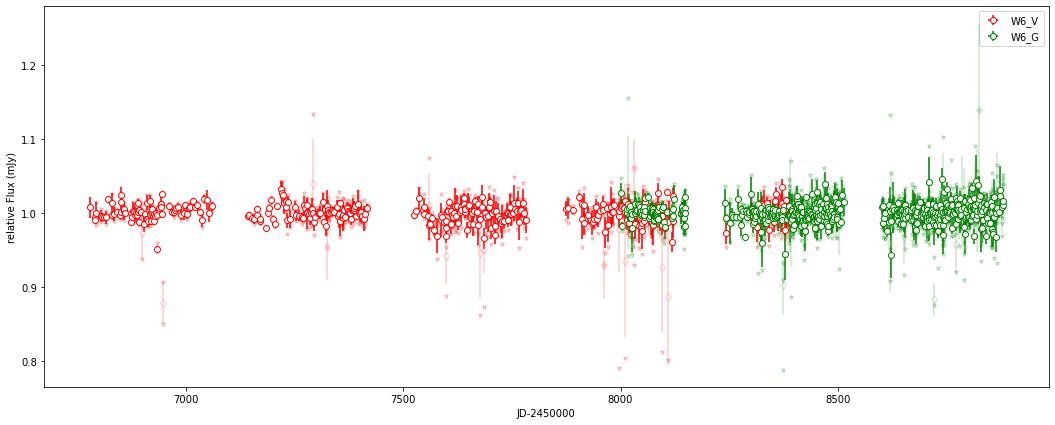

In [112]:
%matplotlib inline
plt.figure(figsize = (18,7))
#
#
#to plot the original data, normalized
RawData = Readcsvdat(filenameMe)
RawDataV, RawTimeV, RawErrV = PullAppropDat(RawData, Key='flux(mJy)',TypeKey='Filter',Type='V')
plt.plot(RawTimeV, RawDataV/MeanF_V , 'r*', alpha =.2)

RawDataG, RawTimeG, RawErrG = PullAppropDat(RawData, Key='flux(mJy)',TypeKey='Filter',Type='g')
plt.plot(RawTimeG, RawDataG/MeanF_g, 'g*', alpha =.2)
#
#
#to plot the normalized binned data, with errorbars 
binRaw_timV, binRaw_fluxV, binRaw_errV = BinnedLC(RawTimeV, RawDataV, RawErrV, diff_lim=.1)
ErrBarsV = [binRaw_errV/MeanF_V, binRaw_errV/MeanF_V]
TimBarsV = [np.zeros(len(binRaw_timV)),np.zeros(len(binRaw_timV))]
plt.errorbar(binRaw_timV, binRaw_fluxV/MeanF_V, ErrBarsV, TimBarsV, 'red', markersize = 6, ls='', marker='d', mfc='white', mew=1, zorder=10, alpha = .2)

binRaw_timG, binRaw_fluxG, binRaw_errG = BinnedLC(RawTimeG, RawDataG, RawErrG,diff_lim=.1)
ErrBarsG = [binRaw_errG/MeanF_g, binRaw_errG/MeanF_g]
TimBarsG = [np.zeros(len(binRaw_timG)),np.zeros(len(binRaw_timG))]
plt.errorbar(binRaw_timG, binRaw_fluxG/MeanF_g, ErrBarsG, TimBarsG, 'green', markersize = 6, ls='', marker='d', mfc='white', mew=1, zorder=10, alpha = .2)
#
#
#to plot the final normalized cut binned data, with errorbars 
NotTimV, NotTimg = np.zeros(len(Final_tV)), np.zeros(len(Final_tg))
plt.errorbar(Final_tV, Final_flxV, [Final_ErrV,Final_ErrV], [NotTimV,NotTimV], 'red', markersize = 6, ls='', marker='o', mfc='white', mew=1, zorder=10, label = 'W6_V')
plt.errorbar(Final_tg, Final_flxg, [Final_Errg,Final_Errg], [NotTimg,NotTimg], 'green', markersize = 6, ls='', marker='o', mfc='white', mew=1, zorder=10, label = 'W6_G')
plt.ylabel('relative Flux (mJy)')
plt.xlabel('JD-2450000')
plt.legend()
plt.show()

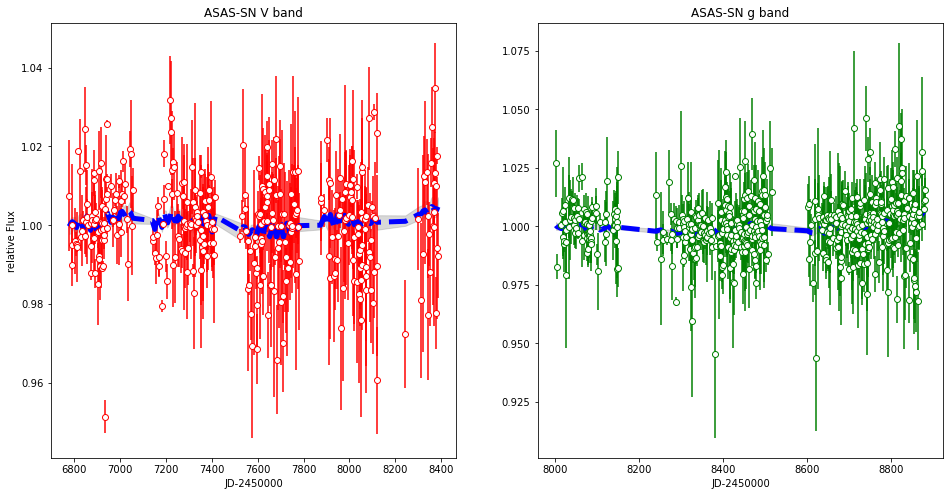

ASAS-SN V band:
Standard deviation: 0.011455936040017274
median absolute deviation: 0.010460158441639333 

ASAS-SN g band:
Standard deviation: 0.011722781456830783
median absolute deviation: 0.008886299987231299 



In [113]:
plt.figure(1, figsize=(16,8))

plt.subplot(121)
plt.title("ASAS-SN V band")
plt.errorbar(Final_tV, Final_flxV, [Final_ErrV,Final_ErrV], [NotTimV,NotTimV], 'red', markersize = 6, ls='', marker='o', mfc='white', mew=1, zorder=10)
modelTimeV = dataset.times_lc['ASASSNv']
modelV, error68_upV, error68_downV = results.lc.evaluate('ASASSNv', return_err=True)
plt.plot(modelTimeV, modelV,'b--', linewidth = 5, zorder=10)
plt.fill_between(modelTimeV, error68_downV, error68_upV, color='grey',alpha = 0.3)
plt.ylabel('relative Flux')
plt.xlabel('JD-2450000')

plt.subplot(122)
plt.title("ASAS-SN g band")
plt.errorbar(Final_tg, Final_flxg, [Final_Errg,Final_Errg], [NotTimg,NotTimg], 'green', markersize = 6, ls='', marker='o', mfc='white', mew=1, zorder=10)
modelTimeG = dataset.times_lc['ASASSNg']
modelG, error68_upG, error68_downG = results.lc.evaluate('ASASSNg', return_err=True)
plt.plot(modelTimeG, modelG,'b--', linewidth = 5, zorder=10)
plt.fill_between(modelTimeG, error68_downG, error68_upG, color='grey',alpha = 0.3)
plt.xlabel('JD-2450000')

plt.show()
plt.close()
allTess_Flux  = np.concatenate((lc_OOT1.flux, lc_OOT1.flux))
print("ASAS-SN V band:")
print("Standard deviation:", np.std(Final_flxV))
print("median absolute deviation:", median_absolute_deviation(Final_flxV),"\n")
print("ASAS-SN g band:")
print("Standard deviation:", np.std(Final_flxg))
print("median absolute deviation:", median_absolute_deviation(Final_flxg),"\n")